# **Stock Prices Predictions with Machine Learning**

This Notebook will contain the modeling phases needed to predict stock prices using a deep learning model.
The stocks analyzed will be the following:
* IBM
* AAPL (Apple Inc.)
* AMZN (Amazon Inc.)
* GOOGL (Alphabet Inc.)


In [184]:
import sagemaker

# Data preparation

Data must be prepared in order to be processed by DeepAR model:
* Train/test set split
* Save Data locally
* Upload to S3

## Save Data Locally

In [185]:
data_dir = 'stock_deepar'

In [211]:
import os

In [212]:
data_dir_csv = os.path.join(data_dir, 'csv') # The folder we will use for storing data
if not os.path.exists(data_dir_csv): # Make sure that the folder exists
    os.makedirs(data_dir_csv)

In [213]:
interval ='D'

In [214]:
# IBM
df_ibm_train.to_csv(os.path.join(data_dir_csv, 'ibm_train.csv'), header=True, index=True)
df_ibm_test.to_csv(os.path.join(data_dir_csv, 'ibm_test.csv'), header=True, index=True)
df_ibm_valid.to_csv(os.path.join(data_dir_csv, 'ibm_valid.csv'), header=True, index=True)

In [215]:
# Apple Inc.
df_aapl_train.to_csv(os.path.join(data_dir_csv, 'aapl_train.csv'), header=True, index=True)
df_aapl_test.to_csv(os.path.join(data_dir_csv, 'aapl_test.csv'), header=True, index=True)
df_aapl_valid.to_csv(os.path.join(data_dir_csv, 'aapl_valid.csv'), header=True, index=True)

In [216]:
# Amazon.com
df_amzn_train.to_csv(os.path.join(data_dir_csv, 'amzn_train.csv'), header=True, index=True)
df_amzn_test.to_csv(os.path.join(data_dir_csv, 'amzn_test.csv'), header=True, index=True)
df_amzn_valid.to_csv(os.path.join(data_dir_csv, 'amzn_valid.csv'), header=True, index=True)

In [217]:
# Alphabet Inc.
df_googl_train.to_csv(os.path.join(data_dir_csv, 'googl_train.csv'), header=True, index=True)
df_googl_test.to_csv(os.path.join(data_dir_csv, 'googl_test.csv'), header=True, index=True)
df_googl_valid.to_csv(os.path.join(data_dir_csv, 'googl_valid.csv'), header=True, index=True)

### JSON serialization

In order to feed DeepAR model, JSON files must be prepared from data.
I'll dispose two kind of JSON inputs:
* one with "dynamic features", to use a DeepAR API terminology: all dataset features except for target column and related one ('Adj Close', 'Close');
* one without "dynamic features: only 'Adj Close' column will be fed to DeepAR model.

### JSON files

Now I'm going to convert data to JSON file format, in order to feed the DeepAR model correctly

As already announced, I will create two kind of time series, one with a list of dynamic features `dyn_feat`and the other one with only the target column (`Adj Close`) time series. 

In [192]:
# initializing train/test dataframe lists to iterate on them
dfs_train = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
dfs_test = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

Creating local storage path:

In [193]:
data_dir_json = os.path.join(data_dir, 'json')
if not os.path.exists(data_dir_json): # Make sure that the folder exists
    os.makedirs(data_dir_json)

Serializing data to json files

In [194]:
from source_deepar.deepar_utils import ts2json_serialize

Dataset with the `Adj Close` time series alone:

Training data:

In [195]:
data_dir_json_train = os.path.join(data_dir_json, 'train') # The folder we will use for storing data
if not os.path.exists(data_dir_json_train): # Make sure that the folder exists
    os.makedirs(data_dir_json_train)

In [196]:
for df, m in zip(dfs_train, mnemonics):
    ts2json_serialize(df, data_dir_json_train, m+'.json')

Test data:

In [197]:
data_dir_json_test = os.path.join(data_dir_json, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test): # Make sure that the folder exists
    os.makedirs(data_dir_json_test)

In [198]:
for df, m in zip(dfs_test, mnemonics):
    ts2json_serialize(df, data_dir_json_test, m+'.json')

Dataset containing dynamic features:

Training data:

In [199]:
data_dir_json_dyn_feat = os.path.join(data_dir_json, 'w_dyn_feat')

In [200]:
data_dir_json_train_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'train') # The folder we will use for storing data
if not os.path.exists(data_dir_json_train_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_train_dyn_feat)

In [201]:
for df, m in zip(dfs_train, mnemonics):
    ts2json_serialize(df, data_dir_json_train_dyn_feat, m+'.json', dyn_feat=['Open'])

Test data:

In [202]:
data_dir_json_test_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_test_dyn_feat)

In [203]:
for df, m in zip(dfs_test, mnemonics):
    ts2json_serialize(df, data_dir_json_test_dyn_feat, m+'.json', dyn_feat=['Open'])

Validation data:

In [204]:
data_dir_json_test_dyn_feat = os.path.join(data_dir_json_dyn_feat, 'test') # The folder we will use for storing data
if not os.path.exists(data_dir_json_test_dyn_feat): # Make sure that the folder exists
    os.makedirs(data_dir_json_test_dyn_feat)

In [205]:
for df, m in zip(dfs_test, mnemonics):
    ts2json_serialize(df, data_dir_json_test_dyn_feat, m+'.json', dyn_feat=['Open'])

## Uploading data to S3

In [186]:

# Define IAM role and session
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

#Define training data location
s3_data_key = 'stock_deepar/train_artifacts'
s3_bucket = sagemaker_session.default_bucket()
interval = 'D' #Use D or H
s3_output_path = "s3://{}/{}/{}/output".format(s3_bucket, s3_data_key, interval)


In [184]:
# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(data_dir_json, 'train')
test_prefix    = '{}/{}'.format(data_dir_json, 'test')
train_prefix_dyn_feat   = '{}/{}'.format(data_dir_json_dyn_feat, 'train')
test_prefix_dyn_feat    = '{}/{}'.format(data_dir_json_dyn_feat, 'test')

In [185]:
input_data_train = sagemaker_session.upload_data(path=data_dir_json_train, bucket=s3_bucket, key_prefix=train_prefix)

In [186]:
input_data_test = sagemaker_session.upload_data(path=data_dir_json_test, bucket=s3_bucket, key_prefix=test_prefix)

In [187]:
input_data_train_dyn_feat = sagemaker_session.upload_data(path=data_dir_json_train, bucket=s3_bucket, key_prefix=train_prefix_dyn_feat)

In [188]:
input_data_test_dyn_feat = sagemaker_session.upload_data(path=data_dir_json_test, bucket=s3_bucket, key_prefix=test_prefix_dyn_feat)

### Set DeepAR specific hyperparameters

In [187]:
from source_deepar import deepar_utils

# setting target columns
target_column = 'Adj Close'
    
    
hyperparameters = {
    "prediction_length": str(prediction_length[1]), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length[1]), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}

In [189]:
#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = session.boto_region_name
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)
print("Model will be trained using container image : {}".format(image_name))

Model will be trained using container image : 495149712605.dkr.ecr.eu-central-1.amazonaws.com/forecasting-deepar:1


## Estimator Instantiation

In [190]:
from sagemaker.estimator import Estimator

# instantiate a DeepAR estimator
estimator = Estimator(image_uri=image_name,
                      sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      instance_count=1,
                      instance_type='ml.c4.xlarge',
                      output_path=s3_output_path,
                      hyperparameters=hyperparameters
                      )

## Training Job Creation

Creation of a training job with stand alone time series (no dynamic features provided). Run only if no model has already been trained before.

In [ ]:
%%time
# train and test channels
data_channels = {
    "train": input_data_train,
    "test": input_data_test
}

# fit the estimator
estimator.fit(inputs=data_channels)

## Existing Model Instantiation

Instatiation of a model from existing training artifacts (run only if a model has already been trained before).

In [191]:
model = sagemaker.model.Model(
    model_data='{}/{}/model.tar.gz'.format(s3_output_path, 'forecasting-deepar-2021-03-07-20-20-06-397/output'),
    image_uri= image_name,
    #image=image_name,  # example path for the semantic segmentation in eu-west-1
    role=role)  # your role here; could be different name

#trainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

Remember to **delete the endpoint** at the end of this notebook. A cell at the very bottom of this notebook will be provided, but it is always good to keep, front-of-mind.

In [192]:
endpoint_name = 'DeepAR-ml-spp'

In [193]:
# create a predictor

from sagemaker.predictor import json_serializer, json_deserializer

In [194]:
# run it once, then update the endpoint if needed
%time

endpoint = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name=endpoint_name,
    #content_type="application/json" # specify that it will accept/produce JSON
    # update_endpoint=True, # deprecated
    serializer=json_serializer,
    deserializer=json_deserializer
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
-------------------!

update endpoint if needed:

In [ ]:
%time

# update an endpoint

predictor = estimator.update_endpoint(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
)

In [196]:
from source_deepar.deepar_utils import DeepARPredictor

In [197]:
json_predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
json_predictor.set_prediction_parameters(interval, prediction_length[1])

# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```

## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [238]:
from source_deepar.deepar_utils import series_to_json_obj
import json

In [241]:
def json_predictor_input(input_ts, target_column='Adj Close', dyn_feat=[], start=None, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k], target_column=target_column, dyn_feat=dyn_feat, start=start))

    # specify the output quantiles and samples
    '''configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}
    
    '''
    
    configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles
    }

    request_data = {
            "instances": [instances],
            "configuration": configuration
    }
    
    json_request = json.dumps(request_data)
    
    return json_request

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [ ]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_ibm_train]
target_ts = [df_ibm_test]

json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = json_predictor.predict(json_input_ts)

#print(json_prediction)

### Predicting IBM Stock

In [199]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_ibm_train]
target_ts = [df_ibm_test]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)

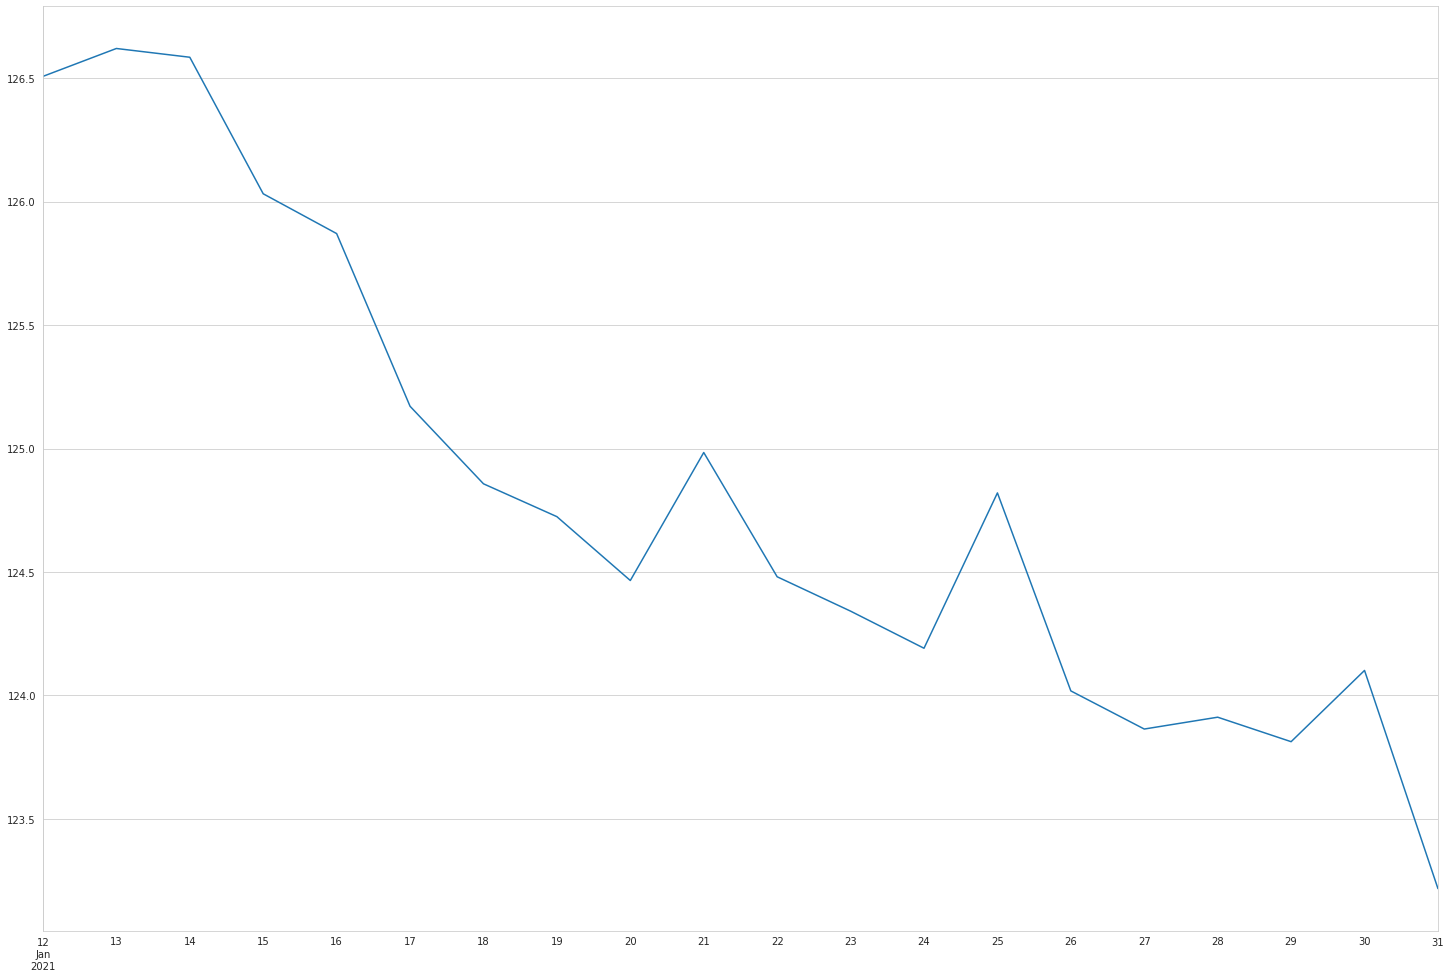

In [200]:
json_prediction[0]['0.5'].plot()

In [306]:
json_prediction[0]

,0.1,0.9,0.5
2021-01-12,122.939148,129.792328,126.507301
2021-01-13,122.850502,129.832214,126.620239
2021-01-14,122.690880,129.614914,126.584770
2021-01-15,121.205780,129.571915,126.031815
2021-01-16,121.498108,129.436279,125.870628
2021-01-17,120.106018,129.764740,125.171249
2021-01-18,120.027161,129.840683,124.857292
2021-01-19,120.266159,129.773026,124.724228
2021-01-20,120.210960,129.179428,124.465637
2021-01-21,119.306801,130.015503,124.984039


Ground truth:

In [308]:
print(target_ts[0].iloc[-(prediction_length[1]):]['Adj Close'])

Date
2021-01-12    127.506165
2021-01-13    125.246353
2021-01-14    127.269318
2021-01-15    126.696968
2021-01-19    127.318665
2021-01-20    128.364685
2021-01-21    129.913971
2021-01-22    117.045937
2021-01-25    117.016335
2021-01-26    120.874763
2021-01-27    120.855034
2021-01-28    118.496552
2021-01-29    117.539337
2021-02-01    118.950485
2021-02-02    117.864990
2021-02-03    117.549210
2021-02-04    119.424149
2021-02-05    120.183998
2021-02-08    121.980003
2021-02-09    122.099998
Name: Adj Close, dtype: float64


### Metrics computation

#### IBM stock

In [247]:
#n = 10
#ma_str = str(n)+'_ac_ma'

In [248]:
#ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid.iloc[n-1:][ma_str])

In [249]:
#print(ibm_ma_mse_loss)

In [250]:
n = 20
ma_str = str(n)+'_ac_ma'

Mean Absolute Error

In [275]:
ibm_ma_mae_loss = mean_absolute_error(df_ibm_valid.iloc[:]['Adj Close'], json_prediction[0]['0.5'])

In [276]:
print(ibm_ma_mae_loss)

3.7456787109313283


Root Mean Squared Error

In [277]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[:]['Adj Close'], json_prediction[0]['0.5'], squared=False)

In [278]:
print(ibm_ma_mse_loss)

4.165544927642503


Mean Absolute Percentage Error

In [279]:
ibm_ma_map_loss = mean_absolute_percentage_error(df_ibm_valid.iloc[:]['Adj Close'], json_prediction[0]['0.5'])

In [280]:
print(ibm_ma_map_loss)

0.030944230248103693


R<sup>2</sup> score

In [281]:
ibm_ma_r2_score = r2_score(df_ibm_valid.iloc[:]['Adj Close'], json_prediction[0]['0.5'])

In [282]:
print(ibm_ma_r2_score)

-2.9087642152162836


In [259]:
#n = 50
#ma_str = str(n)+'_ac_ma'

In [260]:
#ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [261]:
#print(ibm_ma_mse_loss)

## Display the Results

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.

In [323]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, prediction_length, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

In [324]:
# display predictions
display_quantiles(json_prediction, prediction_length[1], target_ts[0])

ValueError: view limit minimum -36891.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36891.05 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

#### Metrics computation

In [213]:
n = 20
ma_str = str(n)+'_ac_ma'

Mean Absolute Error

In [124]:
ibm_ma_mae_loss = mean_absolute_error(df_ibm_valid.iloc[:]['Adj Close'], df_ibm_valid[:][ma_str])

In [125]:
print(ibm_ma_mae_loss)

1.1818041992187502


Root Mean Squared Error

In [126]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[:]['Adj Close'], df_ibm_valid[:][ma_str], squared=False)

In [127]:
print(ibm_ma_mse_loss)

1.5390955629064866


Mean Absolute Percentage Error

In [128]:
ibm_ma_map_loss = mean_absolute_percentage_error(df_ibm_valid.iloc[:]['Adj Close'], df_ibm_valid[:][ma_str])

In [129]:
print(ibm_ma_map_loss)

0.009663348107737448


R<sup>2</sup> score

In [130]:
ibm_ma_r2_score = r2_score(df_ibm_valid.iloc[:]['Adj Close'], df_ibm_valid[:][ma_str])

In [131]:
print(ibm_ma_r2_score)

0.02723162559245773


In [132]:
#n = 50
#ma_str = str(n)+'_ac_ma'

In [133]:
#ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [134]:
#print(ibm_ma_mse_loss)

### Predicting Apple Stock

In [214]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_aapl_train]
target_ts = [df_aapl_test]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)



In [215]:
print(json_prediction)

[                   0.1         0.9         0.5
2021-01-07  124.966141  133.710434  129.518921
2021-01-08  124.867119  133.773071  129.647171
2021-01-09  124.385757  133.364563  129.237198
2021-01-10  123.272110  134.095047  129.878265
2021-01-11  124.112465  133.994354  129.640106
2021-01-12  124.415009  136.922028  130.901855
2021-01-13  124.572411  136.825378  130.627472
2021-01-14  124.404770  136.993866  130.291321
2021-01-15  124.076569  136.886169  130.670990
2021-01-16  124.076393  138.153107  131.160660
2021-01-17  123.285065  139.048508  131.765427
2021-01-18  124.370094  140.550064  130.926865
2021-01-19  124.946037  140.130737  130.881851
2021-01-20  125.189308  143.258240  132.550827
2021-01-21  123.472794  139.811050  131.557358
2021-01-22  123.124748  141.913605  131.499939
2021-01-23  123.020920  140.186432  131.297318
2021-01-24  123.628662  141.317886  131.838501
2021-01-25  124.427841  141.728821  131.928314
2021-01-26  123.563614  140.581131  130.547806]


Ground truth:

In [216]:
print(df_aapl_test.iloc[-(prediction_length[1]):]['Adj Close'])

Date
2021-01-07    130.724655
2021-01-08    131.852966
2021-01-11    128.787552
2021-01-12    128.607819
2021-01-13    130.694702
2021-01-14    128.717667
2021-01-15    126.950294
2021-01-19    127.639267
2021-01-20    131.832993
2021-01-21    136.665771
2021-01-22    138.862503
2021-01-25    142.706757
2021-01-26    142.946396
2021-01-27    141.848038
2021-01-28    136.885452
2021-01-29    131.763107
2021-02-01    133.939850
2021-02-02    134.788589
2021-02-03    133.740158
2021-02-04    137.184998
Name: Adj Close, dtype: float64


### Predicting Amazon.com Stock

In [217]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_amzn_train]
target_ts = [df_amzn_test]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)



In [218]:
print(json_prediction)

[                    0.1          0.9          0.5
2021-01-07  3103.875244  3255.646973  3183.352783
2021-01-08  3110.760742  3264.066895  3173.780029
2021-01-09  3069.394775  3263.605957  3176.585938
2021-01-10  3092.879883  3275.094971  3180.134033
2021-01-11  3082.147461  3280.021729  3184.632812
2021-01-12  3102.078125  3302.175781  3204.151123
2021-01-13  3086.716309  3294.481445  3196.488770
2021-01-14  3105.305908  3311.101074  3207.810059
2021-01-15  3096.487305  3314.914551  3200.523926
2021-01-16  3106.058105  3331.040771  3217.055420
2021-01-17  3134.722656  3364.406738  3226.018311
2021-01-18  3088.201660  3335.793457  3208.609375
2021-01-19  3115.896484  3347.588135  3238.604248
2021-01-20  3116.237061  3363.819824  3226.713379
2021-01-21  3105.863281  3385.596436  3241.212646
2021-01-22  3106.853271  3377.485840  3250.418213
2021-01-23  3085.061279  3390.304688  3255.830566
2021-01-24  3090.060791  3393.720215  3255.502930
2021-01-25  3096.748535  3376.555420  3239.009033

Ground truth:

In [219]:
print(df_amzn_test.iloc[-(prediction_length[1]):]['Adj Close'])

Date
2021-01-07    3162.159912
2021-01-08    3182.699951
2021-01-11    3114.209961
2021-01-12    3120.830078
2021-01-13    3165.889893
2021-01-14    3127.469971
2021-01-15    3104.250000
2021-01-19    3120.760010
2021-01-20    3263.379883
2021-01-21    3306.989990
2021-01-22    3292.229980
2021-01-25    3294.000000
2021-01-26    3326.129883
2021-01-27    3232.580078
2021-01-28    3237.620117
2021-01-29    3206.199951
2021-02-01    3342.879883
2021-02-02    3380.000000
2021-02-03    3312.530029
2021-02-04    3331.000000
Name: Adj Close, dtype: float64


### Predicting Alphabet Inc. Stock

In [220]:
# get all input and target (test) time series
# input_ts = [df_ibm_train, df_aapl_train, df_amzn_train, df_googl_train]
# target_ts = [df_ibm_test, df_aapl_test, df_amzn_test, df_googl_test]

input_ts = [df_googl_train]
target_ts = [df_googl_test]

# get the prediction from the predictor
json_prediction = json_predictor.predict(input_ts)



In [221]:
print(json_prediction)

[                    0.1          0.9          0.5
2021-01-07  1679.881470  1763.668213  1723.757568
2021-01-08  1684.970093  1769.465698  1719.822632
2021-01-09  1659.624878  1767.636597  1720.335693
2021-01-10  1678.443115  1780.066162  1726.919434
2021-01-11  1668.081299  1780.199463  1725.360107
2021-01-12  1679.628540  1790.985962  1736.021240
2021-01-13  1668.636108  1784.489014  1732.065796
2021-01-14  1674.419678  1790.535400  1731.337158
2021-01-15  1667.183228  1792.080200  1726.906128
2021-01-16  1671.154297  1798.102905  1732.709717
2021-01-17  1692.093384  1824.358154  1742.937134
2021-01-18  1670.530518  1810.012817  1737.217773
2021-01-19  1687.705811  1820.018921  1757.901855
2021-01-20  1689.093750  1829.603882  1751.361206
2021-01-21  1681.372559  1843.392700  1761.610718
2021-01-22  1690.414062  1843.050659  1773.397705
2021-01-23  1680.970825  1855.756714  1781.634155
2021-01-24  1692.762085  1867.024048  1786.429688
2021-01-25  1696.905029  1861.865112  1783.089966

Ground truth:

In [222]:
print(df_googl_test.iloc[-(prediction_length[1]):]['Adj Close'])

Date
2021-01-07    1774.339966
2021-01-08    1797.829956
2021-01-11    1756.290039
2021-01-12    1737.430054
2021-01-13    1747.250000
2021-01-14    1730.920044
2021-01-15    1727.619995
2021-01-19    1784.469971
2021-01-20    1880.069946
2021-01-21    1884.150024
2021-01-22    1892.560059
2021-01-25    1894.280029
2021-01-26    1907.949951
2021-01-27    1818.939941
2021-01-28    1853.199951
2021-01-29    1827.359985
2021-02-01    1893.069946
2021-02-02    1919.119995
2021-02-03    2058.879883
2021-02-04    2053.629883
Name: Adj Close, dtype: float64


### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [265]:
df_ibm_valid['Adj Close'].head()

Date
2019-12-27    126.834549
2019-12-30    124.527962
2019-12-31    125.681244
2020-01-02    126.975204
2020-01-03    125.962540
Name: Adj Close, dtype: float64

In [ ]:
# get all input and target (test) time series
input_ts = df_ibm_valid['Adj Close']
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

#print(json_prediction)

## Delete the Endpoint

Try your code out on different time series. You may want to tweak your DeepAR hyperparameters and see if you can improve the performance of this predictor.

When you're done with evaluating the predictor (any predictor), make sure to delete the endpoint.

In [ ]:
## TODO: delete the endpoint
predictor.delete_endpoint()